In [2]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing

import numpy as np

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

from gensim.models import Word2Vec

import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

In [4]:
def jaccard_weights(graph, _subjects, edges):
    sources = graph.node_features(edges.source)
    targets = graph.node_features(edges.target)

    intersection = np.logical_and(sources, targets)
    union = np.logical_or(sources, targets)

    return intersection.sum(axis=1) / union.sum(axis=1)

In [5]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load(
    largest_connected_component_only=True,
    edge_weights=jaccard_weights,
    str_node_ids=True,  # Word2Vec requires strings, not ints
)

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: range=[0, 1], mean=0.0946879, std=0.0918164
        Features: none


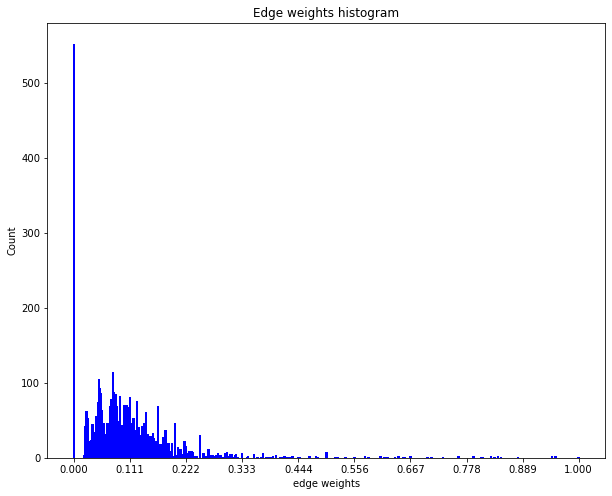

In [7]:
_, weights = G.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

In [8]:
rw = BiasedRandomWalk(G)


In [9]:
weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 24850


In [12]:
weighted_model = Word2Vec(
    weighted_walks,vector_size=128, window=5, min_count=0, sg=1, workers=1
)

In [13]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# E.g., for node id '19231', the embedding vector is retrieved as
emb = weighted_model.wv["19231"]
emb.shape

(128,)

In [14]:
emb

array([-5.76945901e-01,  4.76136088e-01, -1.93139553e-01, -3.84227812e-01,
        3.46366025e-04,  6.74706101e-02,  2.10800484e-01, -3.49261135e-01,
        3.74600291e-01, -3.05182207e-02,  4.71976519e-01, -7.75013492e-02,
        2.54537284e-01, -7.13725448e-01, -6.29579365e-01, -4.14276063e-01,
       -5.55130482e-01,  3.19576353e-01, -4.55112815e-01, -1.39375404e-01,
       -1.78001195e-01, -2.02115625e-01, -5.71447909e-01, -1.36679515e-01,
       -6.92165941e-02, -9.49152038e-02,  1.02325603e-01,  4.43773642e-02,
       -9.74613056e-02, -2.83153117e-01,  2.76696920e-01, -4.29641485e-01,
        4.72708583e-01, -1.91009432e-01,  4.19242948e-01, -4.12687123e-01,
       -1.07593775e+00, -1.88424483e-01, -2.25890741e-01, -1.23799881e-02,
       -3.51461560e-01,  1.19539328e-01, -3.86268198e-01, -1.73563942e-01,
        5.84511220e-01,  1.25312597e-01,  4.11884487e-03,  1.77487060e-01,
        6.31003559e-01,  6.23788476e-01, -1.99822020e-02,  4.46874470e-01,
       -3.24787229e-01, -

In [16]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index_to_key  # list of node IDs
weighted_node_embeddings = (
    weighted_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
node_targets = subjects.loc[node_ids].astype("category")

In [18]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

C:\Users\paya8\AAnaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\paya8\AAnaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


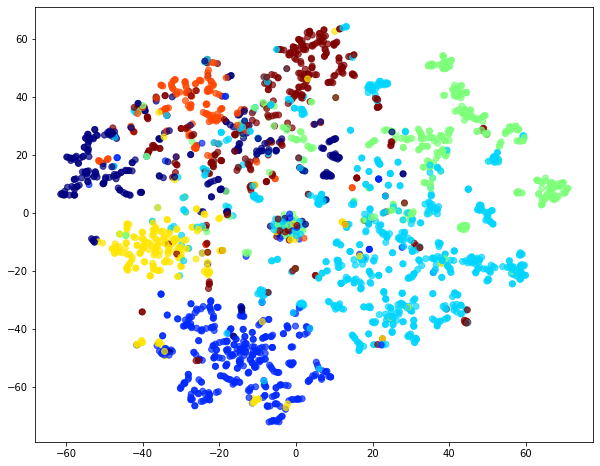

In [19]:
#Plot the embeddings generated from weighted random walks
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [20]:
# X will hold the 128-dimensional input features
X = weighted_node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=None, random_state=42
)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


In [22]:
clf = LogisticRegressionCV(
    Cs=10,
    cv=10,
    tol=0.001,
    max_iter=1000,
    scoring="accuracy",
    verbose=False,
    multi_class="ovr",
    random_state=5434,
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=1000, multi_class='ovr', random_state=5434,
                     scoring='accuracy', tol=0.001, verbose=False)

In [23]:
y_pred = clf.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.7813504823151125